# Modeling the Fire Data for Fires Over 1 Acre and Lasting Longer than 24 Hours

### Again, this notebook is for exploratory models. Without much feature engineering or the removal of outliers. Simply investigating to see if any models could predict the size of fires over 1 acre and lasting longer than 24 hours.

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [58]:
df = pd.read_csv('../../data/processed/master_dataset.csv')
np.random.seed(42)

In [23]:
for i in df.columns:
    print(i)

sum_rain
sum_snow
DiscoveryAcres
total_acres
temp_2m
temp_2m_max
humidity
rain
wind_speed_2m
wind_speed_2m_max
wind_speed_10m
wind_speed_10m_max
surface_soil_wetness_5cm_below
surface_soil_wetness_to_bedrock
landcover_class


---
######
### Investigating Correlation Between the Features and Target (DailyAcres)
######
___

In [24]:
len(df['landcover_class'].unique())

112

In [25]:
df['landcover_class'].value_counts()

158    197
489    160
474    154
187    141
460    121
      ... 
438      1
361      1
165      1
571      1
546      1
Name: landcover_class, Length: 112, dtype: int64

In [42]:
cols = ['sum_rain', 'sum_snow', 'DiscoveryAcres', 'total_acres', 'temp_2m', 'temp_2m_max', 'humidity', 'rain', 'wind_speed_2m', 'wind_speed_2m_max', 'wind_speed_10m', 
        'wind_speed_10m_max', 'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock']

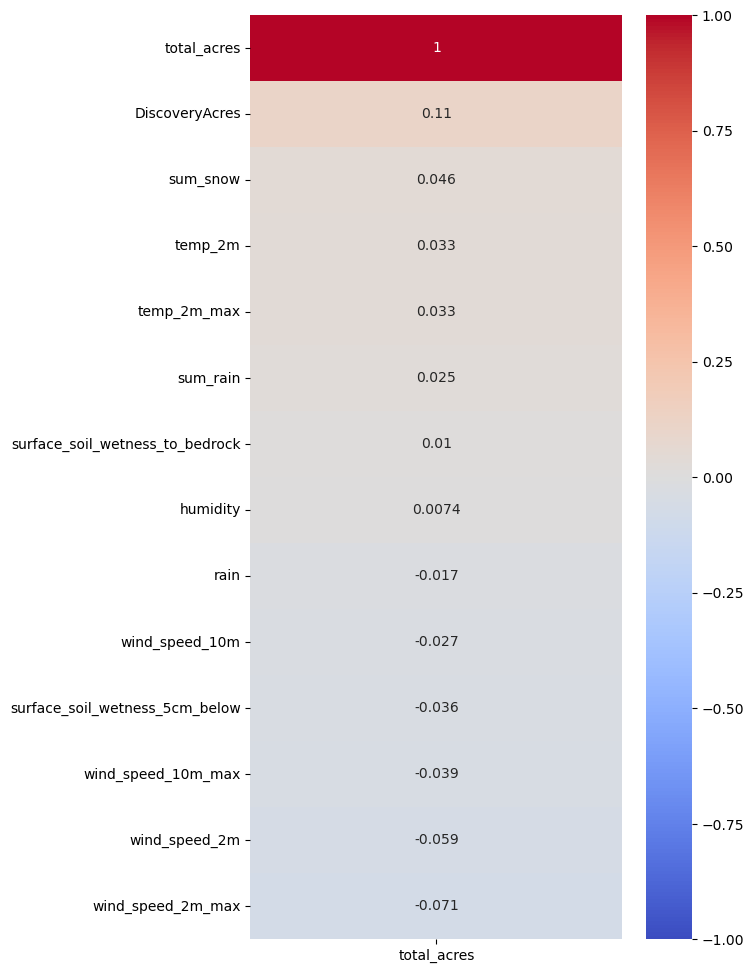

In [43]:
plt.figure(figsize = (6, 12))
sns.heatmap(df[cols].corr()[['total_acres']].sort_values(by = 'total_acres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Train/Test Splitting Data, Standard Scaling, and PCA
######
___

In [59]:
#df1 = pd.get_dummies(data = df, columns = ['landcover_class'], drop_first= True)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'total_acres'), df['total_acres'], random_state= 42)

In [60]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [61]:
pca = PCA(random_state = 42)


Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [62]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:30], 3)

array([0.311, 0.521, 0.64 , 0.721, 0.792, 0.863, 0.913, 0.943, 0.968,
       0.982, 0.992, 0.999, 1.   , 1.   ])

In [63]:
Z_train = Z_train[:,:13]
Z_test = Z_test[:,:13]

---
######
### Dummying Landcover_Class and re-train/test splitting
######
___

In [64]:
df = pd.get_dummies(data = df, columns = ['landcover_class'], drop_first= True)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'total_acres'), df['total_acres'], random_state= 42)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [66]:
#np.savetxt('../../data/processed/Neural_Net_Data/X_train_bigfires.csv', X_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_test_bigfires.csv', X_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_bigfires.csv', Z_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_bigfires.csv', Z_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_train_bigfires.csv', y_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_test_bigfires.csv', y_test, delimiter=',')

---
######
### Modeling / Simple Models
######
---

#### Linear Regression (Baseline) with DF

In [67]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.25554767647807486
Testing R-Squared: -2.059237398375738e+19
RMSE: 97083961840647.98


#### Linear Regression (Baseline) with PCA

In [68]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.03724593115656627
Testing R-Squared: 0.0031521068515574235
RMSE: 21360.36797712279


In [69]:
def model_eval(model, param_dict, training_data):
    '''
    This function gridsearches a model (arg: model, instantiated before function call) over the given parameters (param_dict) 
    and evalutated on the given training data (either X from DF or Z from PCA'd components)
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        gs_model.fit(X_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(X_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(X_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(X_test, y_test)}')
        
    elif training_data == 'Z_train':
        gs_model.fit(Z_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(Z_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(Z_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(Z_test, y_test)}')
    else:
        return 'Try Again'

#### KNN Regression with DF

In [70]:
#KNN Regressor with X Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.0007408  -0.0915046  -0.00094257 -0.09084575 -0.00067751 -0.08992046
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]
  warnings.warn(


Best Score: -0.0007407992972904509
Best Params: {'n_neighbors': 1000, 'weights': 'uniform'}
RMSE: 21382.499896643734
Training R-Squared: 0.00182827821914322
Testing R-Squared: 0.0010853272063349184


#### KNN Regression with PCA Data

In [71]:
#KNN Regressor with PCA Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [ 0.00045171 -0.07367803 -0.00031839 -0.07219463 -0.00054041 -0.07077581
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]
  warnings.warn(


Best Score: 0.0004517126494439916
Best Params: {'n_neighbors': 1000, 'weights': 'uniform'}
RMSE: 21341.749024914538
Training R-Squared: 0.0029544890727408735
Testing R-Squared: 0.004889171886495958


#### Lasso Regression with DF

In [72]:
# Lasso Regression with X Data

lasso = Lasso()
lasso_params = {
    'alpha': range(5, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: -0.011674854062340145
Best Params: {'alpha': 99}
RMSE: 21521.04495613612
Training R-Squared: 0.2521694116980826
Testing R-Squared: -0.011901278515964675


#### Lasso Regression with PCA

In [73]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': range(5, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: 0.011950392572275814
Best Params: {'alpha': 99}
RMSE: 21310.087963312733
Training R-Squared: 0.0357042332359383
Testing R-Squared: 0.007839529422299485


#### Adaboost Regression with DF

In [74]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: -0.7107480062486895
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 27012.390803839404
Training R-Squared: 0.03603381763624147
Testing R-Squared: -0.5941804678184106


#### Adaboost Regression with PCA

In [75]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: -0.6119897988105538
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 26949.06347548211
Training R-Squared: 0.10395031134038724
Testing R-Squared: -0.5867144977028558


#### RandomForest Regression with DF

In [55]:
# Random Forest with X_train

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'X_train')

Best Score: -0.07112835860314744
Best Params: {'ccp_alpha': 1, 'max_depth': 100, 'min_samples_leaf': 3, 'min_samples_split': 2}
RMSE: 21604.412892553966
Training R-Squared: 0.4368058168141158
Testing R-Squared: -0.019756242638423682


#### RandomForest Regression with PCA

In [56]:
# Random Forest with PCA

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'Z_train')

Best Score: -0.08591852238321925
Best Params: {'ccp_alpha': 0.5, 'max_depth': 170, 'min_samples_leaf': 3, 'min_samples_split': 3}
RMSE: 21885.035621872514
Training R-Squared: 0.4477194446398408
Testing R-Squared: -0.04641980545504465


---
######
### Modeling / Ensemble Models
######
---

#### Stacking Regression with DF and with DecisionTreeRegressor Final Estimator

In [76]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -0.47920810490337873
Testing R-Squared: -0.8461747087254479
RMSE: 29069.039428523763


#### Stacking Regression with PCA and with DecisionTreeRegressor Final Estimator

In [77]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.6673124283299503
Testing R-Squared: -0.3895135149545048
RMSE: 25218.87273464506


#### Stacking Regression with DF and with LinearRegression Final Estimator

In [78]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.1522922849877597
Testing R-Squared: -0.00023057208212184932
RMSE: 21396.57915524863


#### Stacking Regression with PCA and with LinearRegression Final Estimator

In [79]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.048228248815116226
Testing R-Squared: -0.004118200818812534
RMSE: 21438.12022012956


#### Stacking Regression with DF and with Lasso Final Estimator

In [80]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.1340944262657875
Testing R-Squared: -0.0003364835281025602
RMSE: 21397.71193538704


#### Stacking Regression with PCA and with Lasso Final Estimator

In [81]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.03744072414785937
Testing R-Squared: 0.005384419187990708
RMSE: 21336.43767732687


#### Stacking Regression (different base estimators) with DF and with Lasso Final Estimator

In [82]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.21648778061717222
Testing R-Squared: 0.0027147553656451384
RMSE: 21365.053227651155


#### Stacking Regression (different base estimators) with PCA and with Lasso Final Estimator

In [83]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.025931524193041566
Testing R-Squared: 0.002069637975198879
RMSE: 21371.962353811738


#### Voting Regression with DF

In [84]:
#Voting Classifier with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(X_train, y_train)
print(f'Training R-Squared: {vote.score(X_train, y_train)}')
print(f'Testing R-Squared: {vote.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(X_test), squared = False)}')

Training R-Squared: 0.2726236217268123
Testing R-Squared: -0.4029810390772708
RMSE: 25340.791945215773


#### Voting Regression with PCA

In [85]:
#Voting Classifier with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: 0.44587545423643515
Testing R-Squared: -0.18931616164864407
RMSE: 23331.51514234441
